AR composites of sea-level pressure (shading) and 500-hPa height contours


## Imports

In [2]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap

In [3]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [4]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

### ERA5 renalysis

In [5]:
# Select lat/lon grid
lonmin = 30
lonmax = 120
latmin = 0
latmax = 60

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open HUV data
filepath_pattern = path_to_data + 'ERA5/huvq/daily/out.era5_hma_05dg_daily_huvq_*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')

# open SLP data
filepath_pattern = path_to_data + 'ERA5/mslp/daily/out.era5_hma_025dg_daily_mslp_*.nc'
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')


# Create new dataset to rename lat lon
ds = xr.Dataset({'H': (['time', 'lat', 'lon'], f1['z'].sel(level=500.).values),
                 'SLP': (['time', 'lat', 'lon'], f2['msl'].values)},
                      coords={'time': (['time'], f2.time.values),
                              'lat': (['lat'], f2.latitude.values),
                              'lon': (['lon'], f2.longitude.values)})

ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))


ds size in GB 2.56



### AR Days

In [6]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-djf.csv'
df = pd.read_csv(filepath)


In [7]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
ds = ds.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
ds['ar'] = ('time', df.AR_CAT)
ds = ds.set_coords('ar')

In [8]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    # print results
    print(era_ar)
    
    return era_ar

# Lag=0, -2, +2
era_ar_lag0 = select_ar_days(era=ds, lag=0)
era_ar_lag2 = select_ar_days(era=ds, lag=-2)
era_ar_lead2 = select_ar_days(era=ds, lag=2)

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 181, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 60.0 59.5 59.0 58.5 58.0 57.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 3 3 1 3 3 2 3 3 3 2 1 3 3 ... 3 3 3 3 3 3 3 1 1 2 2 2
Data variables:
    H        (time, lat, lon) float32 51721.945 51685.695 ... 57428.34 57431.773
    SLP      (time, lat, lon) float32 99982.04 100005.77 ... 100932.38 100944.65
<xarray.Dataset>
Dimensions:  (lat: 121, lon: 181, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 60.0 59.5 59.0 58.5 58.0 57.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 3 3 1 3 3 2 3 3 3 2 1 3 3 ... 3 3 3 3 3 3 3 1 1 2 2 2
Data variables:
    H        (ti

### Composites of SALLJ types

In [9]:
# Compute composites of each AR type
era_ar_comp_lag0 = era_ar_lag0.groupby('ar').mean('time')
era_ar_comp_lag2 = era_ar_lag2.groupby('ar').mean('time')
era_ar_comp_lead2 = era_ar_lead2.groupby('ar').mean('time')

# combine lag datasets into 1 ds object
era_ar_comp = xr.concat([era_ar_comp_lead2, era_ar_comp_lag0, era_ar_comp_lag2], pd.Index([-2, 0, 2], name='lag'))
era_ar_comp

<xarray.Dataset>
Dimensions:  (ar: 3, lag: 3, lat: 121, lon: 181)
Coordinates:
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
  * lat      (lat) float32 60.0 59.5 59.0 58.5 58.0 57.5 ... 2.0 1.5 1.0 0.5 0.0
  * ar       (ar) int64 1 2 3
  * lag      (lag) int64 -2 0 2
Data variables:
    H        (lag, ar, lat, lon) float32 51993.023 51995.418 ... 57451.71
    SLP      (lag, ar, lat, lon) float32 100707.58 100729.19 ... 101014.336

## Figure 6

In [10]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=13,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                fontweight='extra bold',
                transform=transform)
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n \n' + str(np.int(data[mxy[i], mxx[i]])),
                color=color, size=8, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='center', 
                transform=transform, zorder=10)

### Data for plotting

### Set plot parameters

In [11]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# lat/lon arrays
lats = era_ar_comp.lat.values
lons = era_ar_comp.lon.values
    
# 2d lons/lats (for finding min/max points on map)
lons2d, lats2d = np.meshgrid(lons, lats)

### SLP Figure

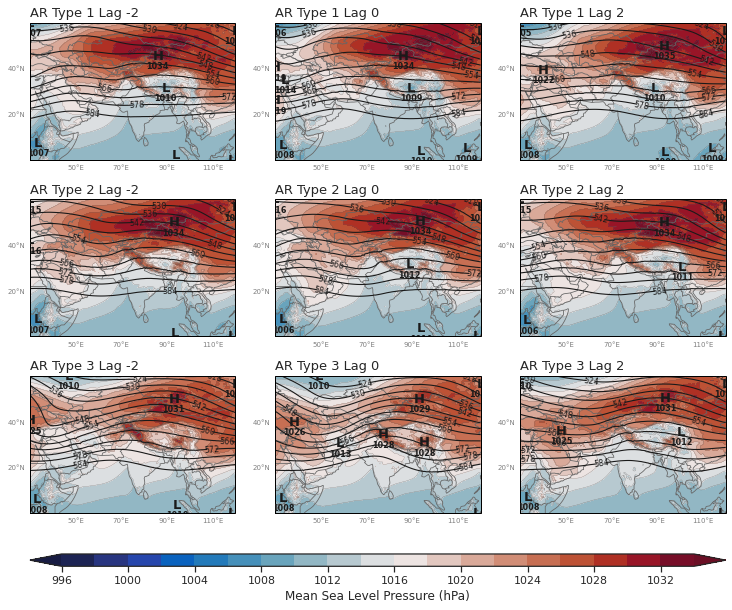

In [12]:
 # Create figure
fig = plt.figure(figsize=(15,10))
nrows = 3
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='',
                direction='column')

# slp
#clevs_slp = np.arange(996,1038+1,2)
cmap= cmo.balance
cmap_slp = cmocean.tools.crop_by_percent(cmap, 7, which='max', N=None)

# loop to draw plots
lag_lst = [-2, -2, -2, 0, 0, 0, 2, 2, 2]
artype_lst = [1, 2, 3, 1, 2, 3, 1, 2, 3]
for k, (ax, lag, ar_type) in enumerate(zip(axgr, lag_lst, artype_lst)):
    data = era_ar_comp.sel(lag=lag, ar=ar_type)
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Plot MSLP
    clevs_slp = np.arange(996,1035+1,2)
    slp = data.SLP.values/ 100.
#     print(slp.max(), slp.min())
    cf = ax.contourf(lons, lats, slp, transform=datacrs,
                     levels=clevs_slp, cmap=cmap_slp, extend='both')
    cfl = ax.contour(lons, lats, slp, transform=datacrs, levels=clevs_slp, 
                     colors='0.37', linewidths=0.3, alpha=0.8)
                    # colors='0.37', linewidths=0.5)
    
    # 500-hPa height lines
    clevs_hgts = np.arange(5000, 6060, 60)
    hgts_500 = data.H.values/(9.80665*10) # convert to geopotential height (m)
    cl = ax.contour(lons, lats, hgts_500, transform=datacrs,
                    levels=clevs_hgts/10, linewidths=1.1,colors='k')# colors='#00009e')
    plt.clabel(cl, fmt='%d', fontsize=8, inline=True, inline_spacing=10, 
               rightside_up=True, use_clabeltext=True) 

    # Add H/L symbols
    slp_smooth = gaussian_filter(slp, sigma=1)
    plot_maxmin_points(lons2d, lats2d, slp_smooth, 'max', 50, 
                       symbol='H', color='k', transform=datacrs)
    plot_maxmin_points(lons2d, lats2d, slp_smooth, 'min', 50, 
                       symbol='L', color='k', transform=datacrs) 
        
    # subtitles
    plt_label = 'AR Type {0} Lag {1}'.format(ar_type, lag)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', extend='both')
cb.set_label('Mean Sea Level Pressure (hPa)')

# Save figure
filepath = path_to_figs + 'ar_types_slp_'+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()


### 500-hPa Heights Figure

In [ ]:
#### VERSION 2 - 500 heights (shading) + SLP contours

 # Create figure
fig = plt.figure(figsize=(15,10))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='')

# cmaps
cmap= cmo.phase
cmap_hgts = cmocean.tools.crop_by_percent(cmap, 8, which='both', N=None)
cmap_hgts2 = cmocean.tools.crop_by_percent(cmap, 12, which='max', N=None)


# Loop for drawing each plot
for k, ax in enumerate(axgr):
    
    # basemap
   # ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=mapcrs)
    ax.add_feature(cfeature.LAND, facecolor='0.9') 
    ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)
    # xticks
    ax.set_xticks(dx, crs=mapcrs)      
    lon_formatter = LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    # yticks
    ax.set_yticks(dy, crs=mapcrs)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    # tick params
    ax.tick_params(direction='out', labelsize=8.5, length=5, pad=2, color='black', right=True)    
           
    # 500-hPa height lines
    clevs_hgts = np.arange(5260, 5960, 60)
    cf = ax.contourf(lons, lats, hgts_500[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts/10, cmap=cmap_hgts2, extend='both')
    clevs_hgts = np.arange(5260, 5960, 60)
    cfl = ax.contour(lons, lats, hgts_500[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts/10, colors='k', linewidths=1.0, zorder=10)
    
    # Plot MSLP
#     clevs_slp = np.arange(980,1038+1,4)
#     slp_smooth = gaussian_filter(slp[k,:,:], sigma=0.5)
#     cl = ax.contour(lons, lats, slp[k,:,:], transform=datacrs, levels=clevs_slp, 
#                      colors='w', linewidths=1.4)

     # Add H/L symbols
    plot_maxmin_points(lons2d, lats2d, slp[k,:,:], 'max', 50, 
                       symbol='H', color='k', transform=datacrs)
    plot_maxmin_points(lons2d, lats2d, slp[k,:,:], 'min', 50, 
                       symbol='L', color='k', transform=datacrs) 
        
    # Subtitles 
    ax.set_title(plt_labels[k], loc='center',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', extend='both')
cb.set_label('500-hPa Geopotential Height')

# Save figure
filepath = home/'Desktop'/'geop500-60-2.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()

